# CSCI E-89 Final Project
## Fernando Trias

For this project, I begin with the data from Leafsnap. This dataset contains images of leaves for 185 tree species. This Notebook is used to process those image for use the training script leaf-run.py.

The first step is to download the raw data from:

The data is provided in `tar` format and you need to run `untar` to extract it.

In [ ]:
!untar leafsnap-dataset.tar

After running `untar` to extract the data, run the rest of this Notebook to the end.

In [1]:
import numpy as np

import cv2
from matplotlib import pyplot as plt
%matplotlib inline

import shutil
import os

from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
K.set_image_dim_ordering('tf')
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


Directory where original images are stored.

In [2]:
leafsnap = 'leafsnap'

Target image size.

In [3]:
image_size=224

# Leafsnap Data Set

Read the table linking images to tree species.

In [4]:
import pandas as pd
df = pd.read_csv('%s/leafsnap-dataset-images.txt' % leafsnap, sep='\t')

Extract the genus from the species name so we can later filter on it. Species is in the form "Genus species", as in "Acer palmatum".

In [5]:
df['genus'] = df['species'].str.split(expand=True)[0]

Skip trees that cannot be reliably identified from a leaf. These include Pine, Spruce, Fir and Cedar.

In [6]:
df2 = df
for skip in ('Pinus', 'Abies', 'Picea', 'Cedrus'):
    df2 = df2[df2['genus'] != skip]

In [7]:
df2.head()

,file_id,image_path,segmented_path,species,source,genus
410,55821,dataset/images/lab/acer_campestre/ny1079-01-1.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,Acer
411,55822,dataset/images/lab/acer_campestre/ny1079-01-2.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,Acer
412,55823,dataset/images/lab/acer_campestre/ny1079-01-3.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,Acer
413,55824,dataset/images/lab/acer_campestre/ny1079-01-4.jpg,dataset/segmented/lab/acer_campestre/ny1079-01...,Acer campestre,lab,Acer
414,55825,dataset/images/lab/acer_campestre/ny1079-02-1.jpg,dataset/segmented/lab/acer_campestre/ny1079-02...,Acer campestre,lab,Acer


Images come in two sources: 'lab' and 'field'. 'field' images show just the leaf. 'lab' images have a reference color bar that we need to remove. An example of each is shown below.

In [8]:
df2.groupby('source').count()

,file_id,image_path,segmented_path,species,genus
source,,,,,
field,6584,6584,6584,6584,6584
lab,20019,20019,20019,20019,20019


All the images are taken with a white background. However, due to lighting and exposure, the exact shade of white may differ between photos.

Below is a 'lab' image with reference color bars.

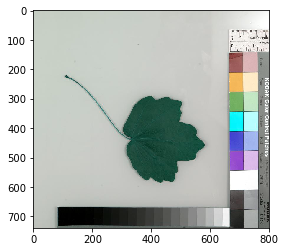

In [9]:
for image in df2[df2.source=='lab'].head().image_path:
    img = cv2.imread("%s/%s" % (leafsnap, image))
    plt.imshow(img)
    break

Below is a 'field' image.

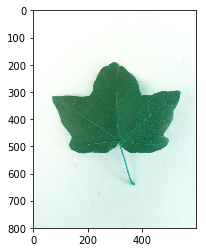

In [15]:
for image in df2[df2.source=='field'].head().image_path:
    img = cv2.imread("%s/%s" % (leafsnap, image))
    plt.imshow(img)
    break

I count how many images we have for each species. Then I show the species with the smallest number of images. The numbers below are small so we will need to use augmentation to make sure all species have a large number of images.

In [16]:
df2.groupby('species').count().sort_values('file_id').head()

,file_id,image_path,segmented_path,source,genus
species,,,,,
Magnolia soulangiana,56,56,56,56,56
Quercus falcata,60,60,60,60,60
Toona sinensis,64,64,64,64,64
Quercus rubra,71,71,71,71,71
Styrax obassia,79,79,79,79,79


# Difficulty of Identification

Different trees can have very similar leaf patterns. To demonstrate this, I will show a sample of each species of Ulmus (Elm) tree in the data set.

First, count the number of species and images for each Elm.

In [56]:
df2[df2.genus=='Ulmus'].groupby('species').count()

,file_id,image_path,segmented_path,source,genus
species,,,,,
Ulmus americana,215,215,215,215,215
Ulmus glabra,160,160,160,160,160
Ulmus parvifolia,165,165,165,165,165
Ulmus procera,120,120,120,120,120
Ulmus pumila,265,265,265,265,265
Ulmus rubra,317,317,317,317,317


Next, get one image from each of the species and show it.

Ulmus americana dataset/images/field/ulmus_americana/1249059004_0000.jpg
Ulmus glabra dataset/images/field/ulmus_glabra/13291717340081.jpg
Ulmus parvifolia dataset/images/field/ulmus_parvifolia/13291720720251.jpg
Ulmus procera dataset/images/lab/ulmus_procera/ny1071-01-1.jpg
Ulmus pumila dataset/images/field/ulmus_pumila/1258770451_0000.jpg
Ulmus rubra dataset/images/field/ulmus_rubra/13002228280378.jpg


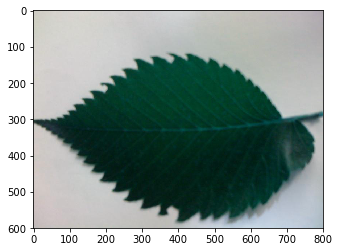

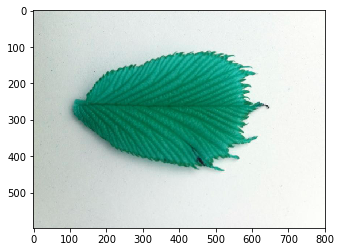

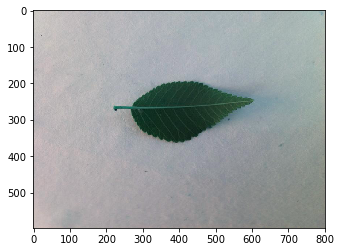

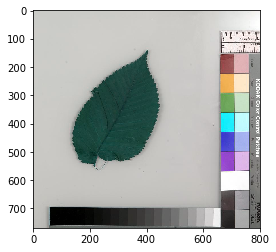

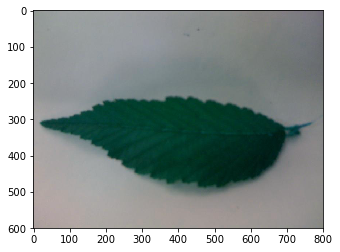

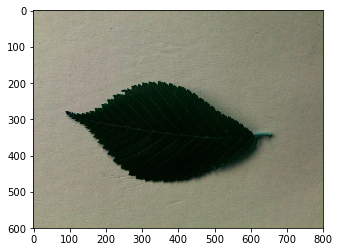

In [90]:
# get one image per Ulmus (Elm) tree type
df3 = df2[df2.genus=='Ulmus'].groupby('species').min()
for name, path in zip(df3.axes[0], df3['image_path']):
    print(name, path)
    img = cv2.imread("%s/%s" % (leafsnap, path))
    plt.figure()
    plt.imshow(img)

As you can see, they all all very similar. They all have toothed edges and ridges on the leaf. They are oval with a point. An expert may be able to distinguish which Elm species each leaf belongs to, but for the most part, this is a difficult problem.

# Create Train/Validation/Test Sets

In [17]:
train_dir = "data/train"
validation_dir = "data/validation"
test_dir = "data/test"

Wipe out any existing data

In [18]:
if os.path.exists('data'):
    shutil.rmtree('data')
os.mkdir('data')

This function will resize the image without distorting the aspect ratio. It will fill any empty portions caused by the resize with color from pixel in upper left corner.

In [19]:
def resize_padded(img, new_shape, fill_cval=None, order=1):
    import numpy as np
    fill_cval = img[1,1] # np.min(img)
    if img.shape[0] > img.shape[1]:
        ratio = img.shape[0] / new_shape[0]
    else:
        ratio = img.shape[1] / new_shape[1]
    img2 = cv2.resize(img, (0,0), fx = 1/ratio, fy = 1/ratio)
    new_img = np.empty(new_shape)
    new_img.fill(fill_cval)
    new_img[0:img2.shape[0],0:img2.shape[1]] = img2        
    return(new_img)

The color of the leaf can sometimes be used to identify the tree. However, since the images here are not taken in consistent lighting, they do not accurately reflect the proper color of the leaf. In the real world, the situation may be even worse. Thus, the images are first converted to black and white in order to reduce the training complexity.

This function will take a source image as grayscale, crop out color bars if necessary, and then resize the image, and finally write it out.

In [20]:
def addSampleToDirectory(sourcedir, outdir, samples):
    if not os.path.exists(outdir): os.makedirs(outdir)
    for index, item in samples.iterrows():
        fn = "%s/%s" % (sourcedir, item['image_path'])
        gray = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        
        name = os.path.basename(fn)
        outfn = "%s/%s" % (outdir, name)
        
        # crop color bars in 'lab' images
        if item['source'] == 'lab':
            h=gray.shape[1]-160
            w=gray.shape[0]-100
            gray = gray[0:w, 0:h]

        img3 = resize_padded(gray, (image_size,image_size))
        img4 = (img3 / np.max(img3) * 255).astype(int)
        cv2.imwrite(outfn, img4)

Now process all the images to create the training, validation and test data sets. I reserve 80% for training, 10% for validation and 10% for testing. Because there are not that many images for each species, I tried to maintain a larger training set.

In [21]:
species = df2.groupby('species')
for sp, data in species:
    # get 80% to train, 10% for validation, 10% for test
    name = sp.lower().replace(" ","_")
    train=data.sample(frac=0.8)
    validation=data.drop(train.index)
    test=validation.sample(frac=0.5)
    validation=validation.drop(test.index)
    addSampleToDirectory("leafsnap", "%s/%s" % (train_dir, name), train)
    addSampleToDirectory("leafsnap", "%s/%s" % (validation_dir, name), validation)
    addSampleToDirectory("leafsnap", "%s/%s" % (test_dir, name), test)

# Training

In [22]:
batch_size=32

In [23]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
#         horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

Found 21285 images belonging to 159 classes.


In [24]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

Found 2661 images belonging to 159 classes.


In [25]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

test_generator = test_datagen.flow_from_directory(
        test_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        batch_size=batch_size,
        color_mode='grayscale',
        class_mode='categorical')

Found 2657 images belonging to 159 classes.


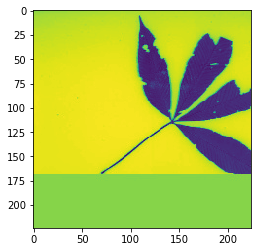

In [26]:
for x, y in test_generator:
    plt.imshow(x[0].reshape(image_size, image_size))
    break